In [234]:
%conda install nbconvert

Note: you may need to restart the kernel to use updated packages.

Solving environment: ...working... done

# All requested packages already installed.



# MTMW14: Numerical Modelling of Atmosphere and Ocean
## Project 1


In this project we will find and use a stable numerical scheme to solve the recharge oscillator model (ROM). This model is used to describe the relationship between the east pacific sea surface temperature (SST) anomaly ($T_E$) and thermocline depth ($h_w$). We will also investigate the effects of nonlinearity and forcing on this model.
ROM is described by two ordinary differential equations:
\begin{equation}
 \frac{dh_w}{dt} = -rh_w -\alpha bT_E - \alpha \xi_1 \\
 \frac{dT_E}{dt} = RT_E + \gamma h_w - e_n{(h_w+bT_E)}^3+ \gamma \xi_1 +\xi_2
 \end{equation}
 where the parameters are described below.

In [211]:
import matplotlib.pyplot as plt
import numpy as np

In [212]:
# Dictionary of the parameters used in Task A - C

setup1 = {'initial_h': 0,       # Initial Thermocline Depth
          'initial_T': 1.125,   # Intitial SST anomaly
          'bo': 2.5,            # high-end value of the coupling parameter
          'gamma': 0.75,        # feedback of thermocline gradient
          'c': 1,               # damping rate
          'r': 0.25,            # damping of upper ocean heat content
          'alpha': 0.125,       # relates wind stress to recharge
          'e_n' : 0,            # degree of non-linearity
          'xi_1' : 0,           # random wind stress forcing
          'xi_2' : 0            # random heating
}

In [213]:
def derived_paras(setup, mu):
    """
    Derive the parameters b (thermocline slope) and R (Bjerknes positive feedback process) 
    from the setup used and value of mu (coupling coefficient)
    """
    b = setup["bo"]*mu
    R = setup["gamma"]*b -setup["c"]
    return b, R

#Functions to non-dimensionalise and re-dimensionalise temperature, depth and time

def nondimensionalise_h(h):
    """
    Non-dimensionalise the thermocline depth by dividing by 150m
    """
    h_New = h/150
    return h_New

def nondimensionalise_T(T):
    """
    Non-dimensionalise the SST anomaly (temperature) by dividing by 7.5K
    """
    T_New = T/7.5
    return T_New

def nondimensionalise_t(t):
    """
    Non-dimensionalise time by dividing by 41 months
    """
    t_New = t/2
    return t_New

def redimensionalise_h(h):
    """
    Re-dimensionalise the thermocline depth by multiplying by 150m
    """
    h_New = h*150
    return h_New

def redimensionalise_T(T):
    """
    Re-dimensionalise the SST anomaly (temperature) by multiplying by 7.5K
    """
    T_New = T*7.5
    return T_New

def redimensionalise_t(t):
    """
    Re-dimensionalise time by multiplying by 41 months
    """
    t_New = t*2
    return t_New

### Task A

For this initial task we have investigated three different finite differences schemes to simulate ROM without external forcing or nonlinearity. The model parameters used were as given above, except we now define the coupling coefficeint ($\mu$) and set this to the critical value $\mu = \mu_c = \frac{2}{3}$.  In order to choose the number time steps ($nt$) to use as well as the size of the time step ($dt$), we considered that the system produces a stable oscillation for a time period of 41 months, so we have initially set $nt  = 41$ and $dt = 1$ to produce one full period. Throughout the project we have non-dimensionalised depth, SST and time as per the functions above, and then re-dimensionalised these values before plotting. Additionally, we have initial conditions: $T_E = 1.125K$ and $h_w = 0m$.

We have chosen three schemes to implement. The first is the Forward in Time (Euler) scheme:
\begin{equation*}
    \frac{h_w^{n+1} - h_w^n}{dt} = {\Big(\frac{dh_w}{dt}\Big)}^n
\end{equation*}
where $dt$ is the step length, we apply the same formula for $T_E$ for all the schemes introduced. This scheme is the simplest to implement and is first order accurate. The second scheme we chose is the  Centred in Time (Leapfrog) scheme:
\begin{equation*}
    \frac{h_w^{n+1} - h_w^{n-1}}{2dt} = {\Big(\frac{dh_w}{dt}\Big)}^n
\end{equation*}
This scheme is an improvement to the previous as it is second order accurate. However, as we require two time steps to calculate the next step we must use the Foward in Time scheme for the initial time step calculation. The final scheme is the Fourth-Order Accurate Runge-Kutta scheme:
\begin{equation*}
h_w^{n+1} = h_w^{n} + \Delta t \frac{1}{6} (k_1 + 2k_2 + 2k_3 + k_4) \\
k_1 = \frac{dh_w}{dt}\big(h_w^{n}, n\Delta t  \big), k_2 = \frac{dh_w}{dt}\big(h_w^{n} + \frac{k_1 \Delta t}{2}, (n + \frac{1}{2}) \Delta t  \big), \\
k_3 = \frac{dh_w}{dt}\big(h_w^{n} + \frac{k_2 \Delta t}{2}, (n + \frac{1}{2}) \Delta t  \big), k_4 = \frac{dh_w}{dt}\big(h_w^{n} + k_3 \Delta t, (n + 1) \Delta t  \big)
\end{equation*}
This differs to our previous schemes as it is iterative. 

We produced time series plots for the thermocline depth, SST anomaly and a phase plot for each scheme below.


In [214]:
# Finite differences schemes to solve ROM
def forward(setup, initial_h, initial_T, alpha, r, gamma, nt, dt, mu=2 / 3):
    """
    Forward in time finite differences scheme to solve for h (depth) and T
    (SST anomaly) for nt times steps and parameters from a setup dictionary
    """
    # Derived parameters
    b, R = derived_paras(setup, mu)

    # new time-step arrays for h and T
    h = np.zeros(nt + 1)
    T = np.zeros(nt + 1)
    
    #initial conditions
    h[0] = initial_h
    T[0] = initial_T

    for i in range(nt):
        h[i + 1] = h[i] + dt * (-r * h[i] - alpha * b * T[i])
        T[i + 1] = T[i] + dt * (R * T[i] + gamma * h[i])

    return h, T


def centred(setup, initial_h, initial_T, alpha, r, gamma, nt, dt, mu=2 / 3):
    """
    Centred in time (Leapfrog) finite differences scheme to solve for h (thermocline depth) and T
    (SST anomaly) for nt times steps and parameters from a setup dictionary. First time step uses 
    forward in time numerical scheme.
    """
    b, R = derived_paras(setup, mu)

    h, T = np.zeros(nt + 1), np.zeros(nt + 1)

    h[0], T[0] = initial_h, initial_T

    # first time step uses forward in time function
    h[1] = h[0] + dt * (-r * h[0] - alpha * b * T[0])
    T[1] = T[0] + dt * (R * T[0] + gamma * h[0])

    for i in range(1, nt):
        h[i + 1] = h[i - 1] + 2 * dt * (-r * h[i] - alpha * b * T[i])
        T[i + 1] = T[i - 1] + 2 * dt * (R * T[i] + gamma * h[i])

    return h, T

# function for ROM
def f(h, T, setup, mu, b, R, e_n=0, xi_1=0):
    """
    ROM function contains the ODEs to be solved for h and T, setup is the dictionary 
    of parameters and additional parameters mu, b, R, e_n, sigma_1
    """
    # set parameters
    bo = setup["bo"]
    gamma = setup["gamma"]
    c = setup["c"]
    r = setup["r"]
    alpha = setup["alpha"]
    xi_2 = setup["xi_2"]

    # Initialize the ROM equations
    dhdt = -r * h - alpha * b * T - alpha * xi_1
    dTdt = R * T + gamma * h - e_n * (h + b * T) ** 3 + gamma * xi_1 + xi_2
    return dhdt, dTdt


def rk4(initial_h, initial_T, setup, nt, dt, mu=2 / 3, e_n=0):
    """
    Iterative 4th order Runge_Kutta scheme solves ROM for initial conditions,
    setup parameters, nt time steps and dt is the step size.
    Mu (couping coefficient) is set to the critical value 2/3 and
    e_n (non-linearity) is set to 0 unless changed.
    """
    
    h, T = np.zeros(nt + 1), np.zeros(nt + 1)

    h[0], T[0] = initial_h, initial_T

    b, R = derived_paras(setup, mu)

    # RK4 routine
    k1, k2, k3, k4 = np.zeros(2), np.zeros(2), np.zeros(2), np.zeros(2)

    for i in range(nt):
        k1 = f(h[i], T[i], setup, mu, b, R, e_n)
        k2 = f(h[i] + k1[0] * dt / 2, T[i] + k1[1] * dt / 2, setup, mu, b, R, e_n)
        k3 = f(h[i] + k2[0] * dt / 2, T[i] + k2[1] * dt / 2, setup, mu, b, R, e_n)
        k4 = f(h[i] + k3[0] * dt, T[i] + k3[1] * dt, setup, mu, b, R, e_n)
        h[i + 1] = h[i] + dt * (k1[0] + 2 * k2[0] + 2 * k3[0] + k4[0]) / 6
        T[i + 1] = T[i] + dt * (k1[1] + 2 * k2[1] + 2 * k3[1] + k4[1]) / 6
    return h, T

In [215]:
def task_A(setup, nt, dt):
    """
    Three finite difference schemes to solve ROM, parameters from the setup,
    nt time steps and dt is step length. Produce time series plots for T and h,
    and a phase plot for each scheme.
    """

    # set time array
    t = np.arange(0, (nt+1) * dt, dt)

    # Non-dimensionalised temperature, depth and time
    h_nd = nondimensionalise_h(setup["initial_h"])
    T_nd = nondimensionalise_T(setup["initial_T"])
    dt_nd = nondimensionalise_t(dt)     # non-dimensionalise dt

    # solve using forward in time differences scheme
    result = forward(setup, h_nd, T_nd, setup["alpha"], setup["r"], setup["gamma"], nt, dt_nd)
    # solve using centred in time differences scheme
    result1 = centred(setup, h_nd, T_nd, setup["alpha"], setup["r"],
                      setup["gamma"], nt, dt_nd)
    # solve using RK4
    result2 = rk4(h_nd, T_nd, setup, nt, dt_nd)

    # redomensionalise temperature and depth
    h_forward = redimensionalise_h(result[0])
    T_forward = redimensionalise_T(result[1])
    h_centred = redimensionalise_h(result1[0])
    T_centred = redimensionalise_T(result1[1])
    h_rk = redimensionalise_h(result2[0])
    T_rk = redimensionalise_T(result2[1])
    
    # Plot SST time series
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize = (20, 4.8))
    fig.suptitle('SST Anomaly Time Series')
    ax1.plot(t, T_forward)
    ax1.set_title('Forward in Time')
    ax2.plot(t, T_centred)
    ax2.set_title('Centred in Time')
    ax3.plot(t, T_rk)
    ax3.set_title('Runge-Kutta')
    ax1.set_xlabel('Time (months)')
    ax2.set_xlabel('Time (months)')
    ax3.set_xlabel('Time (months)')
    ax1.set_ylabel('SST Anomaly (K)')
    plt.show()
    print('Figure 1: Time series plots for SST anomaly over one period for the three numerical schemes.')
    
    # Plot depth time series
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize = (20, 4.8))
    fig.suptitle('Thermocline Depth Time Series')
    ax1.plot(t, h_forward)
    ax1.set_title('Forward in Time')
    ax2.plot(t, h_centred)
    ax2.set_title('Centred in Time')
    ax3.plot(t, h_rk)
    ax3.set_title('Runge-Kutta')
    ax1.set_xlabel('Time (months)')
    ax2.set_xlabel('Time (months)')
    ax3.set_xlabel('Time (months)')
    ax1.set_ylabel('Thermocline Depth (m)')
    plt.show()
    print('Figure 2: Time series plots for thermocline depth over one period for the three numerical schemes.')
    
    # Plot phase plots for foward in time
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize = (20, 4.8))
    fig.suptitle('Phase Plots')
    ax1.plot(h_forward, T_forward)
    ax1.set_title('Forward in Time')
    ax2.plot(h_centred, T_centred)
    ax2.set_title('Centred in Time')
    ax3.plot(h_rk, T_rk)
    ax3.set_title('Runge-Kutta')
    ax1.set_xlabel('Thermocline Depth (m)')
    ax2.set_xlabel('Thermocline Depth (m)')
    ax3.set_xlabel('Thermocline Depth (m)')
    ax1.set_ylabel('SST Anomaly (K)')
    plt.show()
    print('Figure 3: Phase plots for thermocline depth and SST anomaly over one period for the three numerical schemes.')

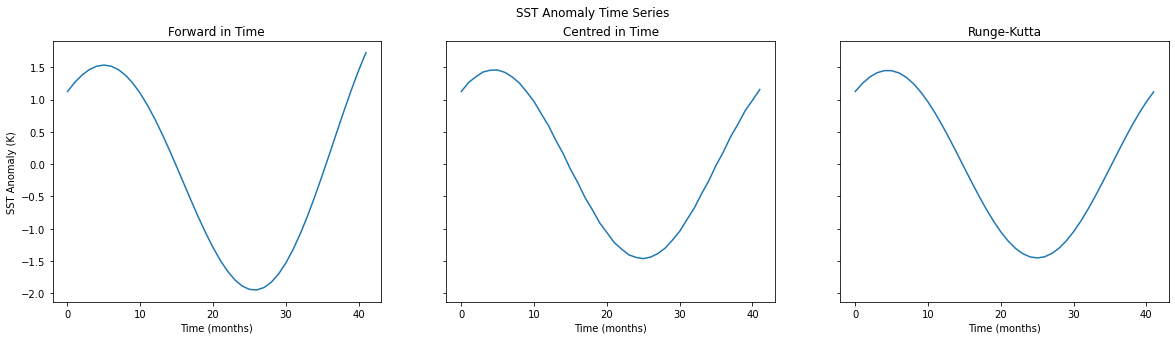

Figure 1: Time series plots for SST anomaly over one period for the three numerical schemes.


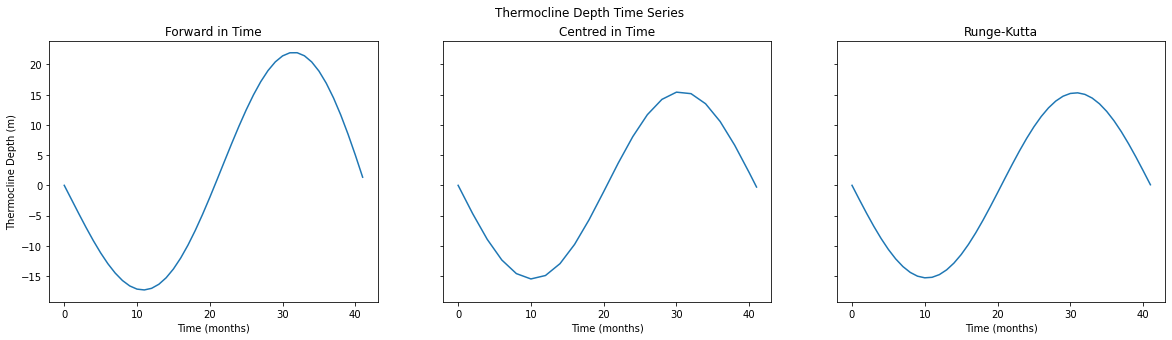

Figure 2: Time series plots for thermocline depth over one period for the three numerical schemes.


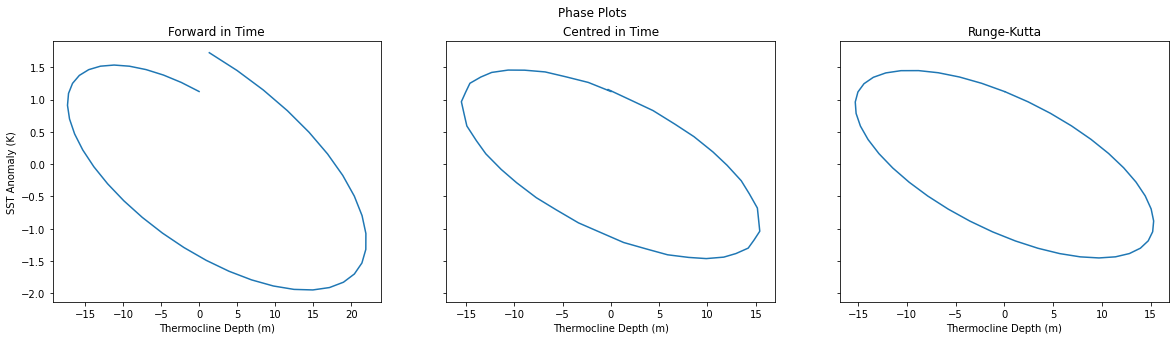

Figure 3: Phase plots for thermocline depth and SST anomaly over one period for the three numerical schemes.


In [216]:
task_A(setup1.copy(), 41, 1)

The numerical method we will use to solve ROM for the rest of the project needs to be stable. We can see from Figure 1 that the Forward in Time scheme may be unstable due to its spiral shape. In order to test whether the schemes are stable we have run them all for 30,000 time steps.

In [217]:
def task_A_stability(setup, nt, dt):
    """
    Test to stability of the finite differences schemes by running for multiple
    periods, nt.  Parameters from the setup and dt is step length.
    """
    t = np.arange(0, (nt + 1) * dt, dt)

    h_nd, T_nd, dt_nd = nondimensionalise_h(setup["initial_h"]),\
                         nondimensionalise_T(setup["initial_T"]),\
                         nondimensionalise_t(dt)
    result, result1, result2 = forward(setup, h_nd, T_nd, setup["alpha"], setup["r"], setup["gamma"], nt, dt_nd),\
                               centred(setup, h_nd, T_nd, setup["alpha"], setup["r"], setup["gamma"], nt, dt_nd),\
                               rk4(h_nd, T_nd, setup, nt, dt_nd)
    
    h_forward, T_forward = redimensionalise_h(result[0]), redimensionalise_T(result[1])
    h_centred, T_centred = redimensionalise_h(result1[0]), redimensionalise_T(result1[1])
    h_rk, T_rk  = redimensionalise_h(result2[0]), redimensionalise_T(result2[1])
    
    # Plot phase plots for foward in time
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 4.8))
    fig.suptitle(f'Phase Plots for {nt} time steps')
    ax1.plot(h_forward, T_forward)
    ax1.set_title('Forward in Time')
    ax2.plot(h_centred, T_centred)
    ax2.set_title('Centred in Time')
    ax3.plot(h_rk, T_rk)
    ax3.set_title('Runge-Kutta')
    ax1.set_xlabel('Thermocline Depth (m)')
    ax2.set_xlabel('Thermocline Depth (m)')
    ax3.set_xlabel('Thermocline Depth (m)')
    ax1.set_ylabel('SST Anomaly (K)')
    plt.show()
    print(f'Figure 4: Phase plots for thermocline depth and SST anomaly for 30,000 time steps period for the three '
          f'numerical schemes to test the stability of the schemes.')

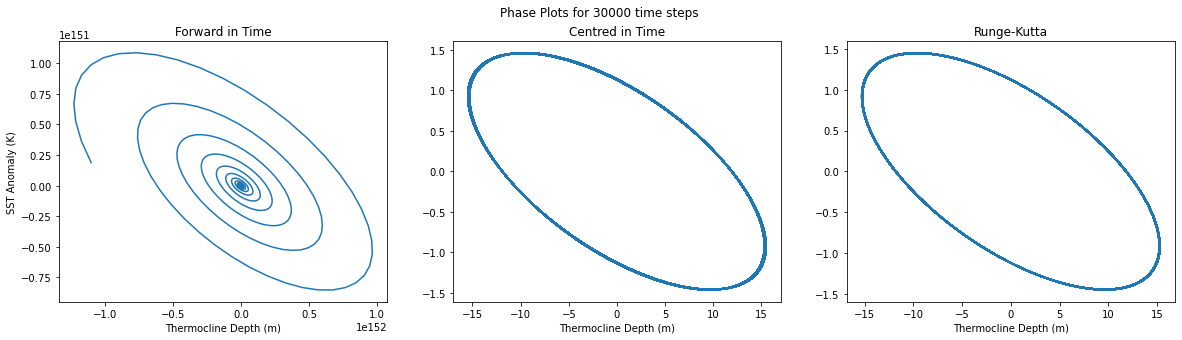

Figure 4: Phase plots for thermocline depth and SST anomaly for 30,000 time steps period for the three numerical schemes to test the stability of the schemes.


In [218]:
task_A_stability(setup1.copy(), 30000, 1)

Over the 30,000 time steps we can immediately see from Figure 4 that the Forward in time scheme is unstable. It initially looks as though both remaining schemes are both stable. The centred scheme varies slightly more near the initial conditions, this will be due to the first time step using the Forward in Time scheme. For this reason we chose the 4th order Runge-Kutta scheme as our stable numerical method to solve ROM.

### Task B

To test the behaviour of ROM for sub-critical and super-critical coupling parameters, we re-ran our model over 5 periods for $\mu = 0.5$ and $\mu = 0.75$. Below we have plotted the time series and phase plots for both scenarios.

In [219]:
def task_B(setup, nt, dt):
    """
    Solve using Rk4 for mu = 0.75 and 0.5. Parameters from the setup,
    nt time steps and dt is step length. Produce time series plots for T and h,
    and a phase plot for each value of mu.
    """
    t = np.arange(0, (nt+1) * dt, dt)

    h_nd, T_nd, dt_nd = nondimensionalise_h(setup["initial_h"]), \
                        nondimensionalise_T(setup["initial_T"]), \
                        nondimensionalise_t(dt)

    big_mu = rk4(h_nd, T_nd, setup, nt, dt_nd, mu=0.75)
    small_mu = rk4(h_nd, T_nd, setup, nt, dt_nd, mu=0.5)

    h_big = redimensionalise_h(big_mu[0])
    T_big = redimensionalise_T(big_mu[1])
    h_small = redimensionalise_h(small_mu[0])
    T_small = redimensionalise_T(small_mu[1])

    # Plot graphs for small mu
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 4.8))
    fig.suptitle('Sub-critical coupling parameter')
    ax1.plot(t, T_small)
    ax1.set_title('SST Anomaly time series')
    ax1.set_xlabel('Time (months)')
    ax1.set_ylabel('SST Anomaly (K)')
    ax2.plot(t, h_small)
    ax2.set_title('Depth time series')
    ax2.set_xlabel('Time (months)')
    ax2.set_ylabel('Thermocline Depth (m)')
    ax3.plot(h_small, T_small)
    ax3.set_title('Phase plot')
    ax3.set_xlabel('Thermocline Depth (m)')
    ax3.set_ylabel('SST Anomaly (K)')
    plt.show()
    print('Figure 5: Time series and phase plots over 5 periods for SST anomaly and thermocline depth with '
          'a subcritical coupling parameter.')
    
    # Plot graphs for large mu
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 4.8))
    fig.suptitle('Super-critical coupling parameter')
    ax1.plot(t, T_big)
    ax1.set_title('SST Anomaly time series')
    ax1.set_xlabel('Time (months)')
    ax1.set_ylabel('SST Anomaly (K)')
    ax2.plot(t, h_big)
    ax2.set_title('Depth time series')
    ax2.set_xlabel('Time (months)')
    ax2.set_ylabel('Thermocline Depth (m)')
    ax3.plot(h_big, T_big)
    ax3.set_title('Phase plot')
    ax3.set_xlabel('Thermocline Depth (m)')
    ax3.set_ylabel('SST Anomaly (K)')
    plt.show()
    print('Figure 6: Time series and phase plots over 5 periods for SST anomaly and thermocline depth with '
          'a subcritical coupling parameter.')

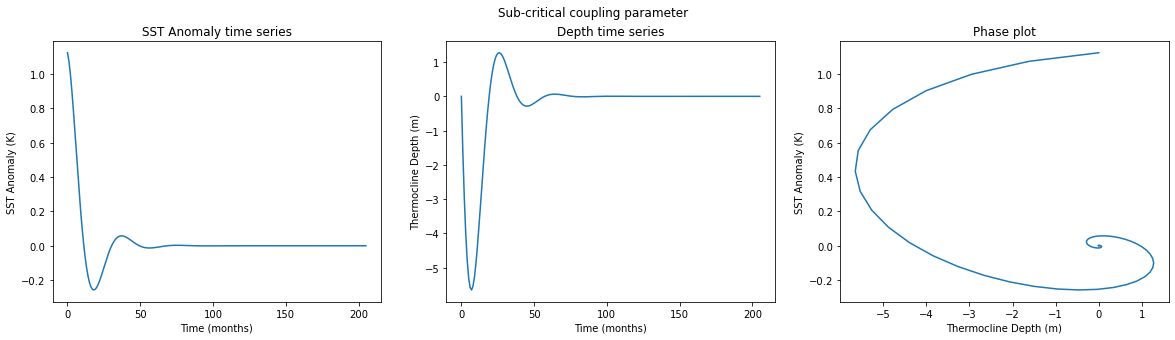

Figure 5: Time series and phase plots over 5 periods for SST anomaly and thermocline depth with a subcritical coupling parameter.


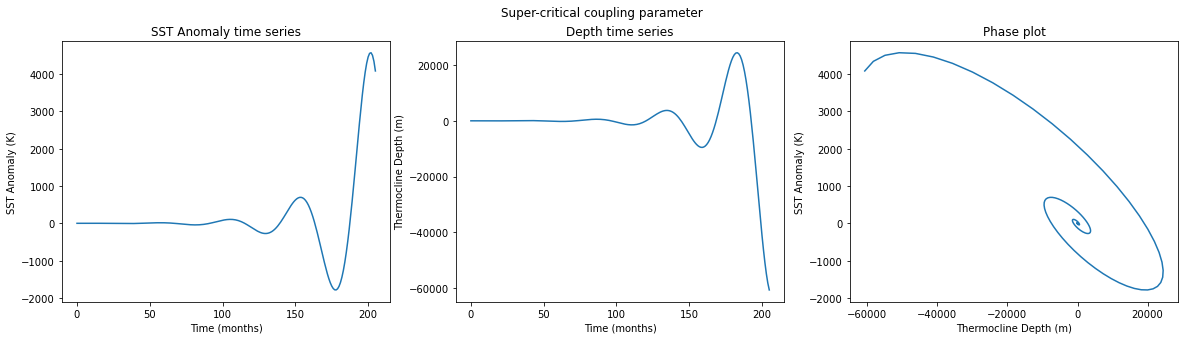

Figure 6: Time series and phase plots over 5 periods for SST anomaly and thermocline depth with a subcritical coupling parameter.


In [220]:
task_B(setup1.copy(), 205, 1)

The sub-critical coupling parameter time series for both thermocline depth and SST anomaly, shown in Figure 5, converges to $0$ for both variables, this cleary indicates that this system has been damped. The phase plot compared to the neutral case in Figure 3 lies within a much smaller domain due to the system quickly converging to $0$. This is because when the coupling coefficient is not sufficiently strong the linear solution to our ODEs decays due to a negative growth rate in the eigen modes, which is described in Jin (1997a).

Alternatively, the super-critical coupling parameter time series of $h_w$ and $T_E$ in Figure 6 explodes and the end points shown are extremly large compared to the neutral case in Figure 3. The phase plot cleary shows this as the system quickly explodes from the inital conditions to the unrealistically large values. This is the opposite to our sub-critical scenario. It is detailed in Jin (1997a) that there is a postiive growth rate in the eigen modes for the super-critical regime.


### Task C
In this section we introduce non-linearlity by setting $e_n = 0.1$. We have run the model for the critical value of $\mu$ and then the super-critical value.

In [221]:
def task_C(setup, nt, dt):
    """
    Solve ROM using RK4 with non-linearity (e_n) turned on, for
    mu=0.5, 0.75. Parameters from the setup, nt time steps and dt is step length.
    """
    #change to non-linearity
    setup["e_n"] = 0.1
    
    t = np.arange(0, (nt+1) * dt, dt)

    h_nd, T_nd, dt_nd = nondimensionalise_h(setup["initial_h"]), \
                        nondimensionalise_T(setup["initial_T"]), \
                        nondimensionalise_t(dt) 
    
    # Non-linearity with critical coupling coefficient
    result = rk4(h_nd, T_nd, setup, nt, dt_nd, e_n = 0.1)

    # Non-linearity with super-critical coupling coefficient
    result1 = rk4(h_nd, T_nd, setup, nt, dt_nd, 0.75, 0.1)

    h_rk = redimensionalise_h(result[0])
    T_rk = redimensionalise_T(result[1])
    h_1 = redimensionalise_h(result1[0])
    T_1 = redimensionalise_T(result1[1])
    
    # Phase plots for non-linearity
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 4.8))
    fig.suptitle('Non-Linearity')
    ax1.plot(h_rk, T_rk)
    ax1.plot(h_rk[-1], T_rk[-1], 'k*')
    ax1.set_title('Critical coupling')
    ax1.set_xlabel('Thermocline Depth (m)')
    ax1.set_ylabel('SST Anomaly (K)')
    ax2.plot(h_1, T_1)
    ax2.plot(h_1[-1], T_1[-1], 'k*')
    ax2.set_title('Super-critical coupling')
    ax2.set_xlabel('Thermocline Depth (m)')
    ax2.set_ylabel('SST Anomaly (K)')
    plt.show()
    print('Figure 7: Phase plots over 5 periods for SST anomaly and thermocline depth with the introduction of '
          'non-linearity. Run for critical and subcritical coupling parameter.')
    

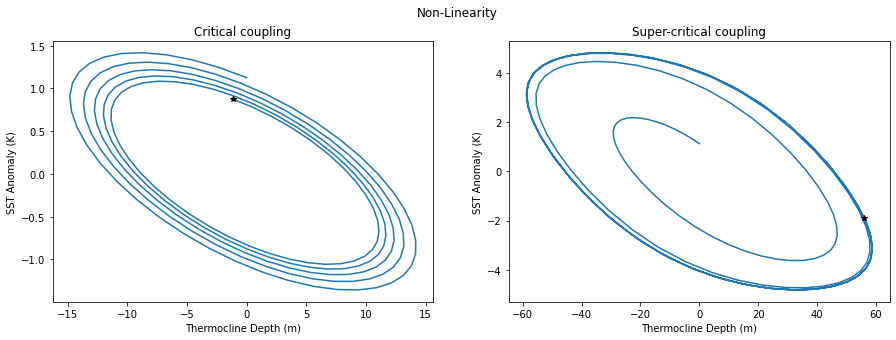

Figure 7: Phase plots over 5 periods for SST anomaly and thermocline depth with the introduction of non-linearity. Run for critical and subcritical coupling parameter.


In [222]:
task_C(setup1.copy(), 205, 1)

In Figure 7 we have introduced non-linearity to our model it begins to spiral inwards for the case of critical coupling. This is shown by the end point marked. It seems that the introduction of non-linearity has slightly damped the system but not to a large degree. The system is converging as each period the trajectories vary less.

The super-critial regime presented in Task B, and shown in Figure 6, has been stabilised by the addition to of non-linearity. The nonlinear processes have limited the linear  growth and led to a finite amplitude oscillation, Jin (1997a).

### Task D
In this task we introduce the annual frequency to our model. This is done by allowing the coupling parameter to vary on an annual cycle using:
\begin{equation*}
\mu = \mu_0 \Big( 1 + \mu_{ann} cos\big(\frac{2\pi t}{\tau} - \frac{5\pi}{6}\big) \Big)
\end{equation*}
where the parameters are as detailed in the dictionary below. The addition of the annual cycle is shown in the rk4_annual function below. The time series and phase plot for this updated model are shown below. 

In [223]:
# Dictionary of the parameters used in Task D - G
annual_wind = {'initial_h': 0,
          'initial_T': 1.125,
          'bo': 2.5,
          'gamma': 0.75,
          'c' : 1,
          'r': 0.25,
          'alpha': 0.125,
          'xi_2' : 0,
          'mu0': 0.75,
          'muann': 0.2,
          'fann' : 0.02,
          'fran' : 0.2,
          'tau' : 12,
          'tau_cor': 1/30           #assumed there are 30 days in a month
}


In [224]:
# Amended runge-kutta scheme for annual cycle variation
def rk4_annual(initial_h, initial_T, setup, tau, nt, dt, e_n=0.1):
    """
    Iterative 4th order Runge_Kutta scheme with coupling parameter to vary on an annual cycle, 
    solves ROM for initial conditions, setup parameters, tau from setup, nt time steps and 
    dt is the step size, e_n (non-linearity) is set to 0.1 unless changed.
    """
    # set parameters for changing derived parameters
    bo = setup["bo"]
    gamma = setup["gamma"]
    c = setup["c"]
    mu0 = setup["mu0"]
    muann = setup["muann"]

    h, T = np.zeros(nt + 1), np.zeros(nt + 1)

    t = np.arange(0, (nt +1) * dt, dt)

    h[0], T[0] = initial_h, initial_T

    k1, k2, k3, k4 = np.zeros(2), np.zeros(2), np.zeros(2), np.zeros(2)
    mu, b, R = 0, 0, 0

    for i in range(nt):
        # calculate new coupling parameter (mu) for the annual cycle
        mu = mu0 * (1 + muann * np.cos(2 * np.pi * t[i] / tau - 5 * np.pi / 6))
        b = bo * mu
        R = gamma * b - c

        k1 = f(h[i], T[i], setup, mu, b, R, e_n)
        k2 = f(h[i] + k1[0] * dt / 2, T[i] + k1[1] * dt / 2, setup, mu, b, R, e_n)
        k3 = f(h[i] + k2[0] * dt / 2, T[i] + k2[1] * dt / 2, setup, mu, b, R, e_n)
        k4 = f(h[i] + k3[0] * dt, T[i] + k3[1] * dt, setup, mu, b, R, e_n)
        h[i + 1] = h[i] + dt * (k1[0] + 2 * k2[0] + 2 * k3[0] + k4[0]) / 6
        T[i + 1] = T[i] + dt * (k1[1] + 2 * k2[1] + 2 * k3[1] + k4[1]) / 6
    return h, T

In [225]:
def task_D(setup, nt, dt):
    """
    Modified ROM to include the annual cycle in coupling parameter.
    Parameters from the setup, nt time steps and dt is step length.
    """
    t = np.arange(0, (nt+1) * dt, dt)

    h_nd, T_nd, dt_nd, tau_nd = nondimensionalise_h(setup["initial_h"]), \
                                nondimensionalise_T(setup["initial_T"]),\
                                nondimensionalise_t(dt), \
                                nondimensionalise_t(setup["tau"])

    result = rk4_annual(h_nd, T_nd, setup, tau_nd, nt, dt_nd)

    h = redimensionalise_h(result[0])
    T = redimensionalise_T(result[1])

    # Plot graphs annual cycle
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 4.8))
    fig.suptitle('Annual Cycle')
    ax1.plot(t, T)
    ax1.set_title('SST Anomaly time series')
    ax1.set_xlabel('Time (months)')
    ax1.set_ylabel('SST Anomaly (K)')
    ax2.plot(t, h)
    ax2.set_title('Depth time series')
    ax2.set_xlabel('Time (months)')
    ax2.set_ylabel('Thermocline Depth (m)')
    ax3.plot(h, T)
    ax3.set_title('Phase plot')
    ax3.set_xlabel('Thermocline Depth (m)')
    ax3.set_ylabel('SST Anomaly (K)')
    plt.show()
    print('Figure 8: Time series and phase plots over 5 periods for SST anomaly and thermocline depth with '
          'a the addition of the annual cycle.')

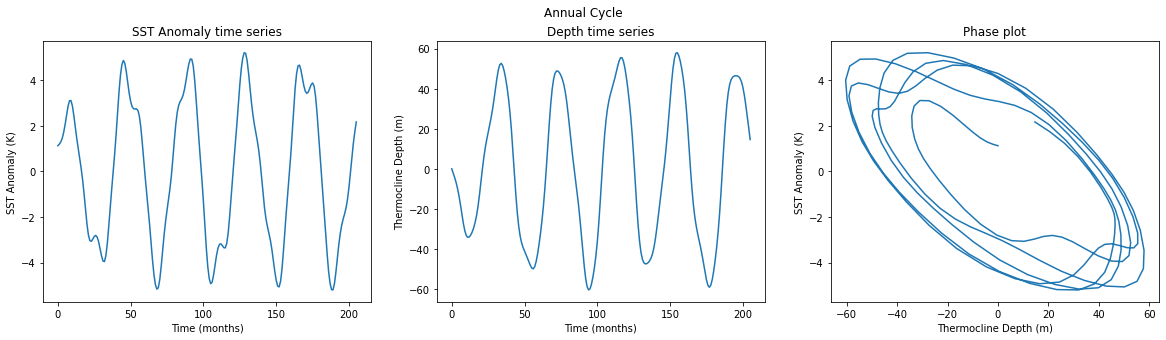

Figure 8: Time series and phase plots over 5 periods for SST anomaly and thermocline depth with a the addition of the annual cycle.


In [226]:
task_D(annual_wind, 205, 1)

Figure 8 shows a more physically realistic model than what we have run in Tasks A - C. We have increased the complexity of the model but with the addition of the annual cycle compared to our previous runs of the model, the model still remains relatively stable, as it is neither damping or exploding.

### Task E and F
In this section we add wind-stress forcing to our model by introducing a function:
\begin{equation*}
\xi_1 = f_{ann}cos(\frac{2\pi t}{\tau}) +f_{ran} W \frac{\tau_{cor}}{\Delta t}
\end{equation*}
for $\xi_1$ as shown in the rk4_wind function below. Here we use some extra parameters that were introduced in our new dictionary in Task D. In particular we note that $-1 \leq W \leq 1$ picked at random (assuming uniform probability for W, lying at any point across the range) after every interval $\tau_{cor}$. This represents a white noise process. The model time-step has been updated to 1 day. We have non-linearity turned off for Task E but for Task F we set $e_n = 0.1$. We have plotted the SST anomaly time series and phase plots to analyse the differences from the previous model runs.

In [227]:
# Amended runge-kutta scheme for additional wind stress forcing
def rk4_wind(initial_h, initial_T, setup, tau, tau_cor, nt, dt, e_n=0, w=None):
    """
   Iterative 4th order Runge_Kutta scheme with wind stress forcing,
    solves ROM for initial conditions, setup parameters, tau and tau_cor from setup,
    nt time steps and dt is the step size, e_n (non-linearity) is set to 0 unless changed.
    W, white noise is random unless given otherwise.
    """
    bo, gamma, c, mu0, muann, fann, fran = setup["bo"], setup["gamma"], setup["c"], setup["mu0"], setup["muann"], \
                                           setup["fann"], setup["fran"]
    h, T = np.zeros(nt + 1), np.zeros(nt + 1)

    t = np.arange(0, (nt + 1) * dt, dt)

    h[0], T[0] = initial_h, initial_T

    k1, k2, k3, k4 = np.zeros(2), np.zeros(2), np.zeros(2), np.zeros(2)
    mu, b, R, xi_1, W = 0, 0, 0, 0, 0

    for i in range(nt):
        mu = mu0 * (1 + muann * np.cos(2 * np.pi * t[i] / tau - 5 * np.pi / 6))
        b = bo * mu
        R = gamma * b - c

        if w is None:
            # White noise different after every tau_cor (=dt)
            W = np.random.uniform(-1, 1)

        else:  # in Task G we will need to remove the random wind forcing
            W = w

        # Add wind stress forcing
        xi_1 = fann * np.cos(2 * np.pi * t[i] / tau) + fran * W * tau_cor / dt

        k1 = f(h[i], T[i], setup, mu, b, R, e_n, xi_1)
        k2 = f(h[i] + k1[0] * dt / 2, T[i] + k1[1] * dt / 2, setup, mu, b, R, e_n, xi_1)
        k3 = f(h[i] + k2[0] * dt / 2, T[i] + k2[1] * dt / 2, setup, mu, b, R, e_n, xi_1)
        k4 = f(h[i] + k3[0] * dt, T[i] + k3[1] * dt, setup, mu, b, R, e_n, xi_1)
        h[i + 1] = h[i] + dt * (k1[0] + 2 * k2[0] + 2 * k3[0] + k4[0]) / 6
        T[i + 1] = T[i] + dt * (k1[1] + 2 * k2[1] + 2 * k3[1] + k4[1]) / 6

    return h, T


In [228]:
def task_EF(setup, nt, dt):
    """
    Modified ROM to include the wind forcing and vary linearity.
    Parameters from the setup, nt time steps and dt is step length.
    """
    t = np.arange(0, (nt+1) * dt, dt)
    h_nd, T_nd, dt_nd, tau_nd, tau_cor_nd= nondimensionalise_h(setup["initial_h"]), \
                                           nondimensionalise_T(setup["initial_T"]),\
                                           nondimensionalise_t(dt),\
                                           nondimensionalise_t(setup["tau"]),\
                                           nondimensionalise_t(setup["tau_cor"])

    result = rk4_wind(h_nd, T_nd, setup, tau_nd, tau_cor_nd, nt, dt_nd)

    #Change e_n to turn on non-linearity
    result1 = rk4_wind(h_nd, T_nd, setup, tau_nd, tau_cor_nd, nt, dt_nd, 0.1)


    h = redimensionalise_h(result[0])
    T = redimensionalise_T(result[1])
    h_e = redimensionalise_h(result1[0])
    T_e = redimensionalise_T(result1[1])

   # Phase plots for non-linearity
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 4.8))
    fig.suptitle('Stochastic Wind Forcing on the linear model')
    ax1.plot(t, T)
    ax1.set_title('SST Anomaly time series')
    ax1.set_xlabel('Time (months)')
    ax1.set_ylabel('SST Anomaly (K)')
    ax2.plot(h, T)
    ax2.plot(h[-1], T[-1], 'k*')
    ax2.set_title('Phase plot')
    ax2.set_xlabel('Thermocline Depth (m)')
    ax2.set_ylabel('SST Anomaly (K)')
    plt.show()
    print('Figure 9: SST time series and phase plot over 5 periods for the linear model, with the addition of '
          'stochastic wind forcing.')
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 4.8))
    fig.suptitle('Stochastic Wind Forcing on the non-linear model')
    ax1.plot(t, T_e)
    ax1.set_title('SST Anomaly time series')
    ax1.set_xlabel('Time (months)')
    ax1.set_ylabel('SST Anomaly (K)')
    ax2.plot(h_e, T_e)
    ax2.plot(h_e[-1], T_e[-1], 'k*')
    ax2.set_title('Phase plot')
    ax2.set_xlabel('Thermocline Depth (m)')
    ax2.set_ylabel('SST Anomaly (K)')
    plt.show()
    print('Figure 10: SST time series and phase plot over 5 periods for the non-linear model, with the addition of '
          'stochastic wind forcing.')

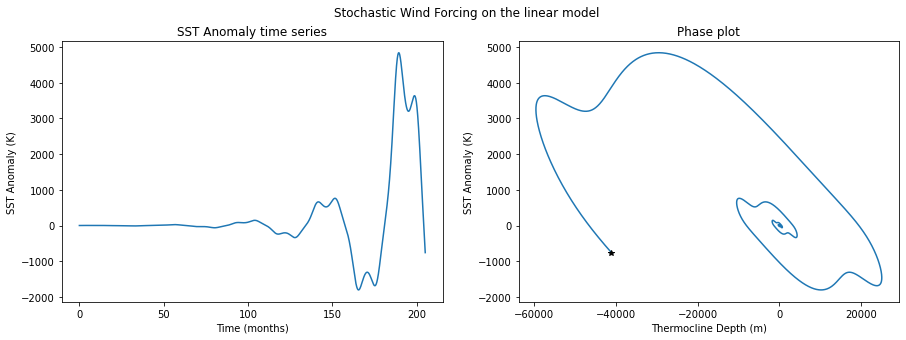

Figure 9: SST time series and phase plot over 5 periods for the linear model, with the addition of stochastic wind forcing.


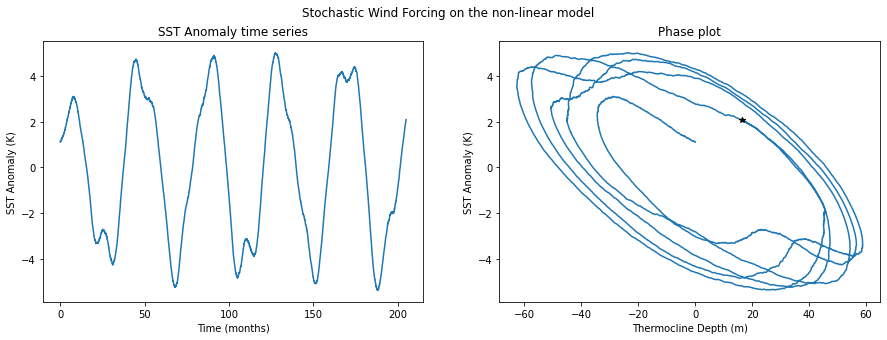

Figure 10: SST time series and phase plot over 5 periods for the non-linear model, with the addition of stochastic wind forcing.


In [229]:
task_EF(annual_wind, 6150, 1/30)

When the stochastic wind forcing has been added to our linear model it is very unstable, the system has exploded as shown in Figure 9. This is similar to the exploding model in Figure 6 for the super-critical coupling parameter. 

Figure 10 shows that the addition of non-linearity actually stabilises the scheme with additional wind forcing. The phase plot looks similar to the phase plot for the annual cycle without the stochastic forcing in Figure 8, where non-linearity was enforced as well. This could imply that the stochastic forcing has less of an effect when introduced into a non-linear model.

### Task G
Here we investigate ensemble forecasts and whether our system is chaotic. Chaotic systems exhibit sensitivity to initial conditions, so we simulate our model 20 times for three different scenarios: random initial conditions and wind forcing, only random wind forcing, only random initial conditions. Our initial conditions are generated from small normally disttibuted pertubations of the initial conditions we have used throughout this project. Below we have produced phase plots and plume diagrams to show the results.

In [230]:
def task_G(setup, nt, dt, n):
    """
    Ensemble forecast from modified ROM to include the wind forcing and vary linearity.
    Parameters from the setup, nt time steps and dt is step length, n is number of forecasts.
    """

    t = np.arange(0, (nt + 1) * dt, dt)
    dt_nd, tau_nd, tau_cor_nd = nondimensionalise_t(dt), nondimensionalise_t(setup["tau"]), \
                                nondimensionalise_t(setup["tau_cor"])
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 4.8))
    fig.suptitle('Ensemble Phase Planes')
    # Ensemble for random initial condition and random wind forcing
    for i in range(n):
        setup_new = setup.copy()
        # Generate initial condition uncertainty
        h_nd = nondimensionalise_h(setup_new["initial_h"] + np.random.normal(0, 0.1))
        T_nd = nondimensionalise_T(setup_new["initial_T"] + np.random.normal(0, 0.1))

        result = rk4_wind(h_nd, T_nd, setup, tau_nd, tau_cor_nd, nt, dt_nd, 0.1)

        # Add new forecast to the phase plot
        ax1.plot(redimensionalise_h(result[0]), redimensionalise_T(result[1]), 'b', zorder=1)
        # Add initial points to plot
        ax1.plot(redimensionalise_h(h_nd), redimensionalise_T(T_nd), 'rx', zorder=2)
        # Add end points to plot
        ax1.plot(redimensionalise_h(result[0][-1]), redimensionalise_T(result[1][-1]), 'k*', zorder=3)
    
    ax1.set_xlabel('Thermocline Depth (m)')
    ax1.set_ylabel('SST Anomaly (K)')
    ax1.set_title('Random initial conditions and wind forcing')

    # Ensemble for only random wind forcing
    for j in range(n):
        result = rk4_wind(nondimensionalise_h(setup["initial_h"]),
                          nondimensionalise_T(setup["initial_T"]), setup,
                          tau_nd, tau_cor_nd, nt, dt_nd, 0.1)

        # Add new forecast to the phase plot
        ax2.plot(redimensionalise_h(result[0]), redimensionalise_T(result[1]), 'g', zorder=1)
        ax2.plot(redimensionalise_h(result[0][-1]), redimensionalise_T(result[1][-1]), 'k*', zorder=2)

    ax2.set_xlabel('Thermocline Depth (m)')
    ax2.set_ylabel('SST Anomaly (K)')
    ax2.set_title('Random wind forcing')

    # Ensemble for random initial condition and random wind forcing
    for k in range(n):
        setup_new = setup.copy()
        h_nd = nondimensionalise_h(setup_new["initial_h"] + np.random.normal(0, 0.1))
        T_nd = nondimensionalise_T(setup_new["initial_T"] + np.random.normal(0, 0.1))

        result = rk4_wind(h_nd, T_nd, setup, tau_nd, tau_cor_nd, nt, dt_nd, 0.1, 0)

        # Add new forecast to the phase plot
        ax3.plot(redimensionalise_h(result[0]), redimensionalise_T(result[1]), 'c', zorder=1)
        ax3.plot(redimensionalise_h(h_nd), redimensionalise_T(T_nd), 'rx', zorder=2)
        ax3.plot(redimensionalise_h(result[0][-1]), redimensionalise_T(result[1][-1]), 'k*', zorder=3)

    ax3.set_xlabel('Thermocline Depth (m)')
    ax3.set_ylabel('SST Anomaly (K)')
    ax3.set_title('Random initial conditions')
    plt.show()

    print('Figure 11: Phase planes for 20 ensembles forecasts over 5 periods')

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 4.8))
    fig.suptitle('Ensemble Plume Diagrams')
    # Ensemble for random initial condition and random wind forcing
    for i in range(n):
        setup_new = setup.copy()

        h_nd = nondimensionalise_h(setup_new["initial_h"] + np.random.normal(0, 0.1))
        T_nd = nondimensionalise_T(setup_new["initial_T"] + np.random.normal(0, 0.1))

        result = rk4_wind(h_nd, T_nd, setup, tau_nd, tau_cor_nd, nt, dt_nd, 0.1)

        ax1.plot(t, redimensionalise_T(result[1]), 'b', zorder=1)
        ax1.plot(0, redimensionalise_T(T_nd), 'rx', zorder=2)
        ax1.plot((nt+1)*dt, redimensionalise_T(result[1][-1]), 'k*', zorder=3)
    ax1.set_title('random initial conditions and wind forcing')
    ax1.set_xlabel('Time (months)')
    ax1.set_ylabel('SST Anomaly (K)')
    # Ensemble for only random wind forcing
    for j in range(n):
        result = rk4_wind(nondimensionalise_h(setup["initial_h"]),
                          nondimensionalise_T(setup["initial_T"]), setup,
                          tau_nd, tau_cor_nd, nt, dt_nd, 0.1)

        ax2.plot(t, redimensionalise_T(result[1]), 'g', zorder=1)
        ax2.plot((nt + 1) * dt, redimensionalise_T(result[1][-1]), 'k*', zorder=2)

    ax2.set_xlabel('Time (months)')
    ax2.set_ylabel('SST Anomaly (K)')
    ax2.set_title('Random wind forcing')
    # Ensemble for random initial condition and random wind forcing
    for k in range(n):
        setup_new = setup.copy()
        h_nd = nondimensionalise_h(setup_new["initial_h"] + np.random.normal(0, 0.1))
        T_nd = nondimensionalise_T(setup_new["initial_T"] + np.random.normal(0, 0.1))
        result = rk4_wind(h_nd, T_nd, setup, tau_nd, tau_cor_nd, nt, dt_nd, 0.1, 0)

        ax3.plot(t, redimensionalise_T(result[1]), 'c', zorder=1)
        ax3.plot(0, redimensionalise_T(T_nd), 'rx', zorder=2)
        ax3.plot((nt + 1) * dt, redimensionalise_T(result[1][-1]), 'k*', zorder=3)
    ax3.set_title('Random initial conditions')
    ax3.set_xlabel('Time (months)')
    ax3.set_ylabel('SST Anomaly (K)')
    plt.show()
    print('Figure 12: SST time series for 20 ensembles forecasts over 5 periods.')


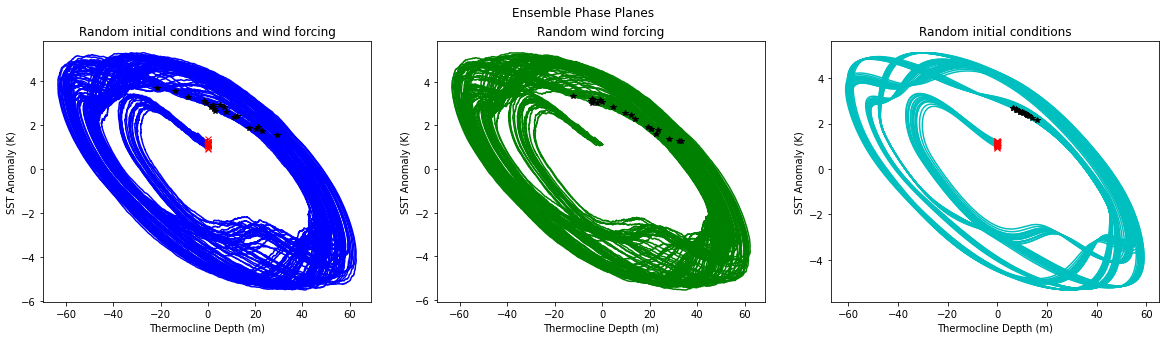

Figure 11: Phase planes for 20 ensembles forecasts over 5 periods


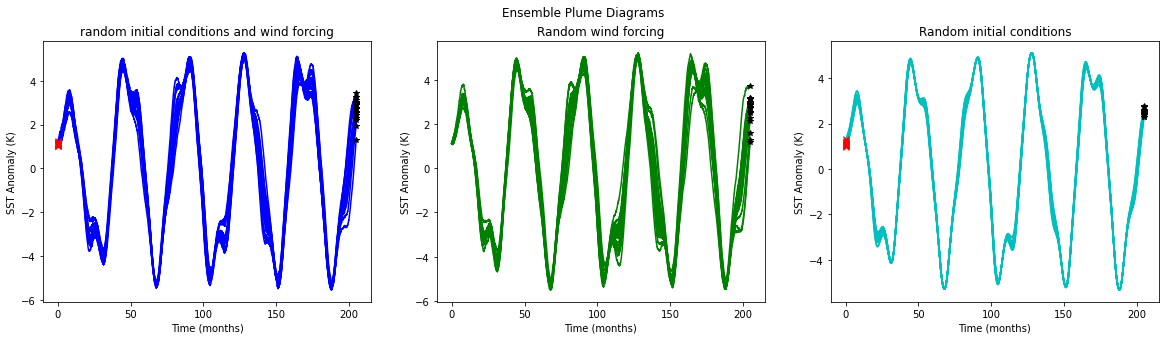

Figure 12: SST time series for 20 ensembles forecasts over 5 periods.


In [231]:
task_G(annual_wind, 6150, 1/30, 20)

Figures 11 and 12 do not show a system that is very sensitive to the initial conditions. For all three experiments of randomness above, the end points are clustering and do not diverge or bifurcate. We can actually see that the system is more sensitive to the random wind forcing than the random initial pertubations. This lack of sensitivity to the initial conditions would lead us to conclude that the ROM is not chaotic. 

The lack of chaos in our system is due to the model being too simple. Vallis (1986) states that three-dimensional bounded dynamical systems with quadratic nonlinearity can be chaotic, however two-dimensional systems, such as our ROM, are restricted to be stationary or have limit-cycle behaviour, as we have seen in many of the experiments above. Vallis states that in order for chaos to occur time-dependent forcing muct be added. So, it would seem that in order for our model to become chaotic we would need to introduce random heat forcing ($\xi_2$) into our model.

### Conclusion

In conclusion, we have presented the Runge_kutta iterative scheme to solve our recharge oscillator model. We have added physical effects such as the annual cycle and wind-stress forcing, as well as non-linearity to make our model more complex and realistic. We have also investigated the effect of varying the coupling coefficient. Overall, we have been able to conclude that ROM is not chaotic due to its simplicity.

### References

Jin, Fei-Fei. "An equatorial ocean recharge paradigm for ENSO. Part I: Conceptual model." Journal of the atmospheric sciences 54, no. 7 (1997a): 811-829.

Jin, Fei-Fei. "An equatorial ocean recharge paradigm for ENSO. Part II: A stripped-down coupled model." Journal of the Atmospheric Sciences 54, no. 7 (1997b): 830-847.

Vallis, Geoffrey K. "El Niño: A chaotic dynamical system?." Science 232, no. 4747 (1986): 243-245.